In [178]:
import pandas as pd
import os

In [179]:
artifacts_path = os.getcwd().removesuffix('notebook\\model')+'artifacts\\'


In [180]:
print(data.to_string())

           Entity  Year  we_avg_yr     fr  median_age       gdp_ppp  Entity_encoded
0         Germany  1990       8.74  1.460      36.600   2915.150994               0
1         Germany  1991        NaN  1.344      36.658   3064.064531               0
2         Germany  1992        NaN  1.305      36.726   3122.988838               0
3         Germany  1993        NaN  1.288      36.838   3092.481927               0
4         Germany  1994        NaN  1.254      37.047   3166.450757               0
5         Germany  1995       9.61  1.262      37.292   3215.345395               0
6         Germany  1996        NaN  1.330      37.536   3241.255385               0
7         Germany  1997        NaN  1.377      37.776   3299.343894               0
8         Germany  1998        NaN  1.364      38.200   3365.790462               0
9         Germany  1999        NaN  1.370      38.669   3429.311718               0
10        Germany  2000      10.14  1.386      39.015   3529.190523         

In [181]:
data = pd.read_csv(artifacts_path + 'eco-1990-2022.csv')

In [182]:
# data['emp_pop_ratio'] = data['emp_pop_ratio'].fillna(data['emp_pop_ratio'].mean())
# data['gdp_ppp'] = data['gdp_ppp'].fillna(data['gdp_ppp'].mean())
# data['fr_ratio'] = data['fr_ratio'].fillna(data['fr_ratio'].mean())

In [183]:
from sklearn.preprocessing import LabelEncoder

# Label encode the 'Entity' column
label_encoder = LabelEncoder()
data['Entity_encoded'] = label_encoder.fit_transform(data['Entity'])

In [184]:
entity_mapper = dict(zip(label_encoder.transform(label_encoder.classes_),label_encoder.classes_))
print(entity_mapper)

{np.int64(0): 'Germany', np.int64(1): 'India', np.int64(2): 'United States'}


In [185]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = data[['Year', 'Entity_encoded']]  # Features
targets = [ 'fr', 'median_age', 'gdp_ppp','we_avg_yr']

# Dictionary to store models and evaluation metrics
models = {}
results = {}

for target in targets:
    print(f"Training model for target: {target}")
    
    # Prepare target data
    Y = data[target]
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    # Initialize and train the Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Save model and results
    models[target] = model
    results[target] = {'MSE': mse, 'R2': r2}
    
    print(f"{target} -> MSE: {mse:.4f}, R2: {r2:.4f}")
    print('------------------------------------')
    
# Results summary
print("\nModel Performance:")
for target, metrics in results.items():
    print(f"{target}: MSE = {metrics['MSE']:.4f}, R2 = {metrics['R2']:.4f}")
    

Training model for target: fr
fr -> MSE: 0.4130, R2: 0.1741
------------------------------------
Training model for target: median_age
median_age -> MSE: 49.0223, R2: 0.2226
------------------------------------
Training model for target: gdp_ppp
gdp_ppp -> MSE: 8111373.5020, R2: 0.8010
------------------------------------
Training model for target: we_avg_yr
we_avg_yr -> MSE: 11.5726, R2: 0.1313
------------------------------------

Model Performance:
fr: MSE = 0.4130, R2 = 0.1741
median_age: MSE = 49.0223, R2 = 0.2226
gdp_ppp: MSE = 8111373.5020, R2 = 0.8010
we_avg_yr: MSE = 11.5726, R2 = 0.1313


In [225]:
test_data_prep = [
    {
        'Year':year,
        'Entity_encoded':entity, 
        'fr':models['fr'].predict(pd.DataFrame([{'Year':year,'Entity_encoded':entity}]))[0], 
    } 
    for entity in data['Entity_encoded'].unique().tolist() for year in pred_year_range
    ]
test_data_prep_df = pd.DataFrame(test_data_prep)

In [231]:
models['fr'].intercept_

np.float64(50.47605735487458)

In [232]:
# Assuming 'model' is the trained LinearRegression model
intercept = models['fr'].intercept_  # Intercept (β0)
coefficients = models['fr'].coef_ # Coefficients for each feature

# Define feature names
feature_names = ['Year', 'Entity_encoded', 'fr', 'median_age', 'we_avg_yr']

# Print the equation
print(f"Intercept (β0): {intercept:.4f}")
for feature, coef in zip(feature_names, coefficients):
    print(f"Coefficient for {feature} (β): {coef:.4f}")

# Construct the linear equation
equation = f"gdp_ppp = {intercept:.4f} + " + " + ".join(
    [f"{coef:.4f} * {feature}" for feature, coef in zip(feature_names, coefficients)]
)
print("\nLinear Equation:")
print(equation)


Intercept (β0): 50.4761
Coefficient for Year (β): -0.0242
Coefficient for Entity_encoded (β): 0.2391

Linear Equation:
gdp_ppp = 50.4761 + -0.0242 * Year + 0.2391 * Entity_encoded


In [236]:
test_data_prep = [
    {
        'Year':year,
        'Entity_encoded':entity, 
        'median_age':models['median_age'].predict(pd.DataFrame([{'Year':year,'Entity_encoded':entity}]))[0], 
    } 
    for entity in data['Entity_encoded'].unique().tolist() for year in pred_year_range
    ]
test_data_prep_df = pd.DataFrame(test_data_prep)

In [237]:
# Assuming 'model' is the trained LinearRegression model
intercept = models['median_age'].intercept_  # Intercept (β0)
coefficients = models['median_age'].coef_ # Coefficients for each feature

# Define feature names
feature_names = ['Year', 'Entity_encoded', 'fr', 'median_age', 'we_avg_yr']

# Print the equation
print(f"Intercept (β0): {intercept:.4f}")
for feature, coef in zip(feature_names, coefficients):
    print(f"Coefficient for {feature} (β): {coef:.4f}")

# Construct the linear equation
equation = f"gdp_ppp = {intercept:.4f} + " + " + ".join(
    [f"{coef:.4f} * {feature}" for feature, coef in zip(feature_names, coefficients)]
)
print("\nLinear Equation:")
print(equation)


Intercept (β0): -447.5314
Coefficient for Year (β): 0.2410
Coefficient for Entity_encoded (β): -2.8745

Linear Equation:
gdp_ppp = -447.5314 + 0.2410 * Year + -2.8745 * Entity_encoded


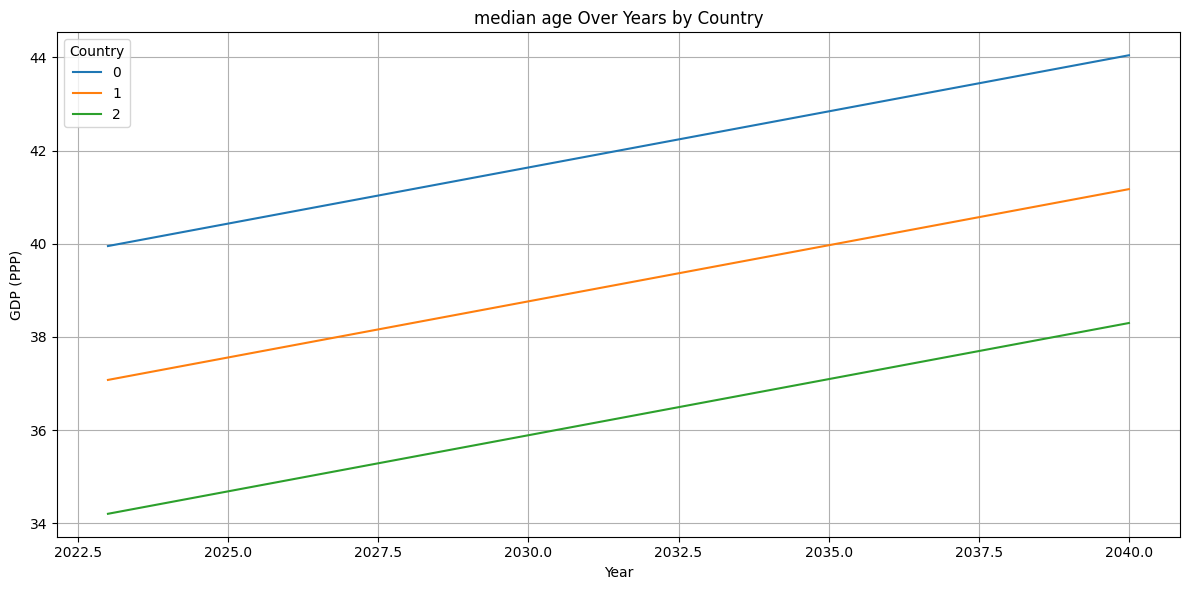

In [238]:
# Create the line chart
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=test_data_prep_df,
    x='Year',
    y='median_age',
    hue='Entity_encoded',  # Different lines for each country
    palette='tab10'  # Optional color palette
)

# Customize the plot
plt.title('median age Over Years by Country')
plt.xlabel('Year')
plt.ylabel('GDP (PPP)')
plt.legend(title='Country')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

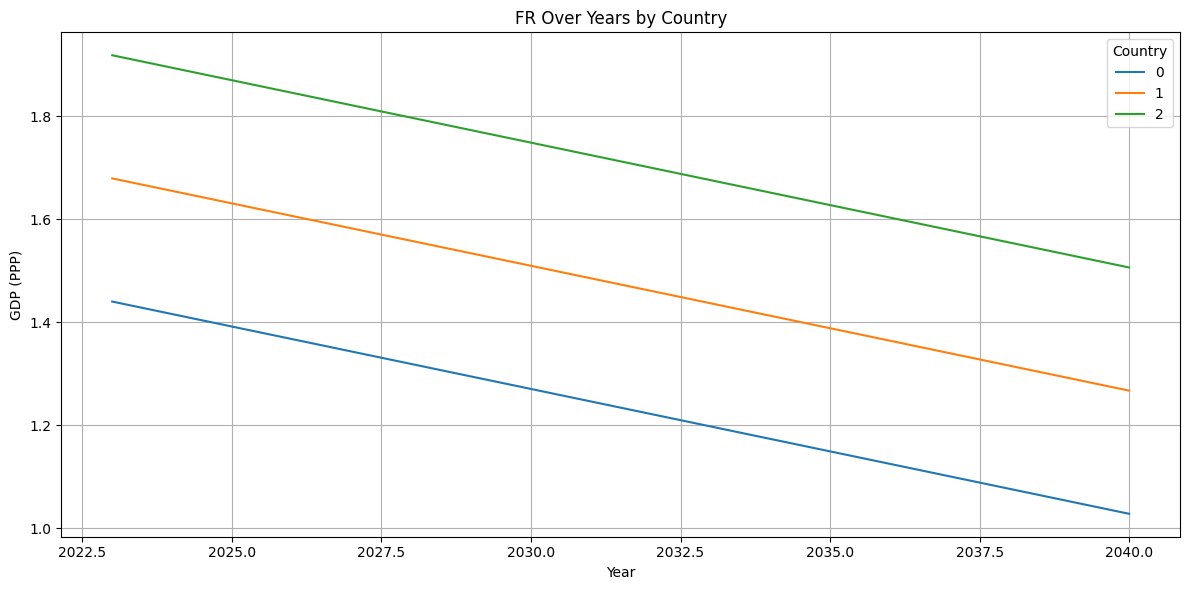

In [234]:
# Create the line chart
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=test_data_prep_df,
    x='Year',
    y='fr',
    hue='Entity_encoded',  # Different lines for each country
    palette='tab10'  # Optional color palette
)

# Customize the plot
plt.title('FR Over Years by Country')
plt.xlabel('Year')
plt.ylabel('GDP (PPP)')
plt.legend(title='Country')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [132]:
pred_year_range = range(2023,2041)

In [135]:
test_data_prep = [{'Year':j,'Entity_encoded':i} for i in data['Entity_encoded'] .unique().tolist() for j in pred_year_range]
test_data_prep_df = pd.DataFrame(test_data_prep)

In [ ]:
models['gdp_ppp'].predict(pd.DataFrame([{'Year':2023,'Entity_encoded':0}]))[0]

np.float64(5753.0309410342015)

In [260]:
X = data[['Year','Entity_encoded','fr', 'median_age','we_avg_yr']]  # Features
Y = data[['gdp_ppp', ]]  # Targets

In [244]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [254]:
print(Y_train[:3].to_string())


         gdp_ppp
49   4024.547309
70  11161.593200
68  10441.989949


In [255]:
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [259]:
X_interaction.shape

(99, 15)

In [247]:
Y_pred = model.predict(X_test)

In [248]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(Y_test, Y_pred, multioutput='raw_values')
r2 = r2_score(Y_test, Y_pred, multioutput='raw_values')

# Define target names
target_names = ['gdp_ppp']

# Print MSE and R² for each target
print("Performance Metrics for Each Target:")
for target, mse_value, r2_value in zip(target_names, mse, r2):
    print(f"- {target}: Mean Squared Error = {round(mse_value, 2)}, R-squared = {round(r2_value, 2)}")

Performance Metrics for Each Target:
- gdp_ppp: Mean Squared Error = 57523.49, R-squared = 1.0


In [249]:
test_data_prep = [
    {
        'Year':year,
        'Entity_encoded':entity, 
        'fr':models['fr'].predict(pd.DataFrame([{'Year':year,'Entity_encoded':entity}]))[0],
        'median_age':models['median_age'].predict(pd.DataFrame([{'Year':year,'Entity_encoded':entity}]))[0],
        'we_avg_yr':models['we_avg_yr'].predict(pd.DataFrame([{'Year':year,'Entity_encoded':entity}]))[0]       
    } 
    for entity in data['Entity_encoded'].unique().tolist() for year in pred_year_range
    ]
test_data_prep_df = pd.DataFrame(test_data_prep)

In [250]:
raw_pred_data = model.predict(test_data_prep_df)

c:\Users\sathy\anaconda3\envs\eco\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


ValueError: X has 5 features, but LinearRegression is expecting 15 features as input.

In [251]:
pred_data = [{'Entity':entity_mapper[i['Entity_encoded']],'Year':i['Year'] ,'gdp_ppp': raw_pred_data[index][0]} for index,i in enumerate(test_data_prep)]
pred_data_df = pd.DataFrame(pred_data)

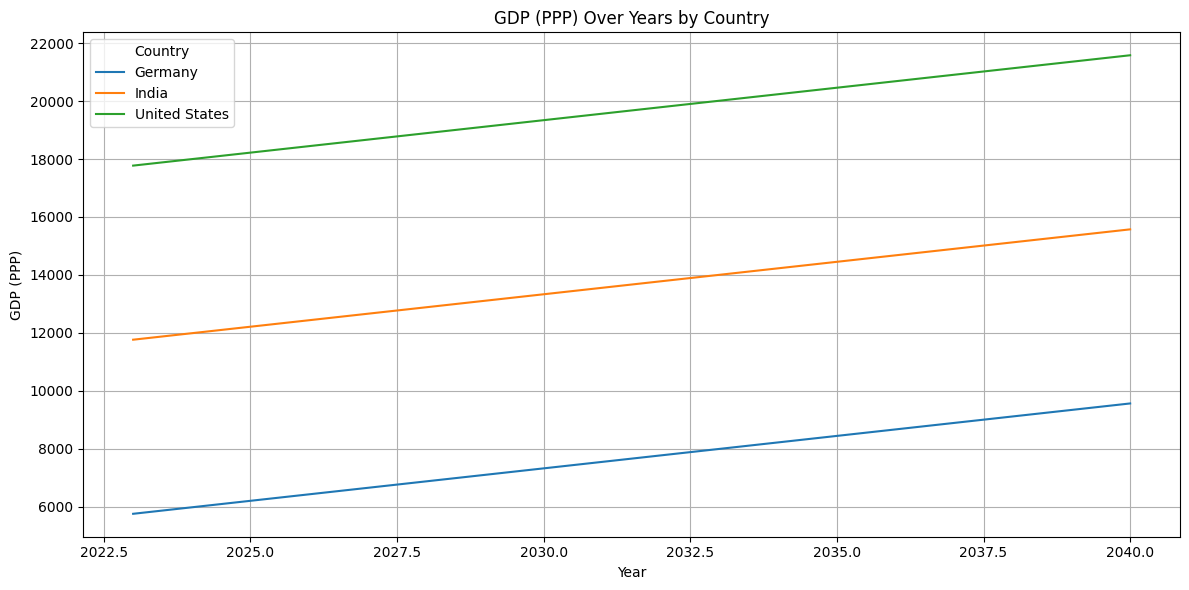

In [221]:
# Create the line chart
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=pred_data_df,
    x='Year',
    y='gdp_ppp',
    hue='Entity',  # Different lines for each country
    palette='tab10'  # Optional color palette
)

# Customize the plot
plt.title('GDP (PPP) Over Years by Country')
plt.xlabel('Year')
plt.ylabel('GDP (PPP)')
plt.legend(title='Country')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [222]:
# Assuming 'model' is the trained LinearRegression model
intercept = model.intercept_[0]  # Intercept (β0)
coefficients = model.coef_[0]   # Coefficients for each feature

# Define feature names
feature_names = ['Year', 'Entity_encoded', 'fr', 'median_age', 'we_avg_yr']

# Print the equation
print(f"Intercept (β0): {intercept:.4f}")
for feature, coef in zip(feature_names, coefficients):
    print(f"Coefficient for {feature} (β): {coef:.4f}")

# Construct the linear equation
equation = f"gdp_ppp = {intercept:.4f} + " + " + ".join(
    [f"{coef:.4f} * {feature}" for feature, coef in zip(feature_names, coefficients)]
)
print("\nLinear Equation:")
print(equation)


Intercept (β0): -198342.0083
Coefficient for Year (β): 90.8158
Coefficient for Entity_encoded (β): 14951.5747
Coefficient for fr (β): -4762.6705
Coefficient for median_age (β): 1529.0441
Coefficient for we_avg_yr (β): -3231.2242

Linear Equation:
gdp_ppp = -198342.0083 + 90.8158 * Year + 14951.5747 * Entity_encoded + -4762.6705 * fr + 1529.0441 * median_age + -3231.2242 * we_avg_yr


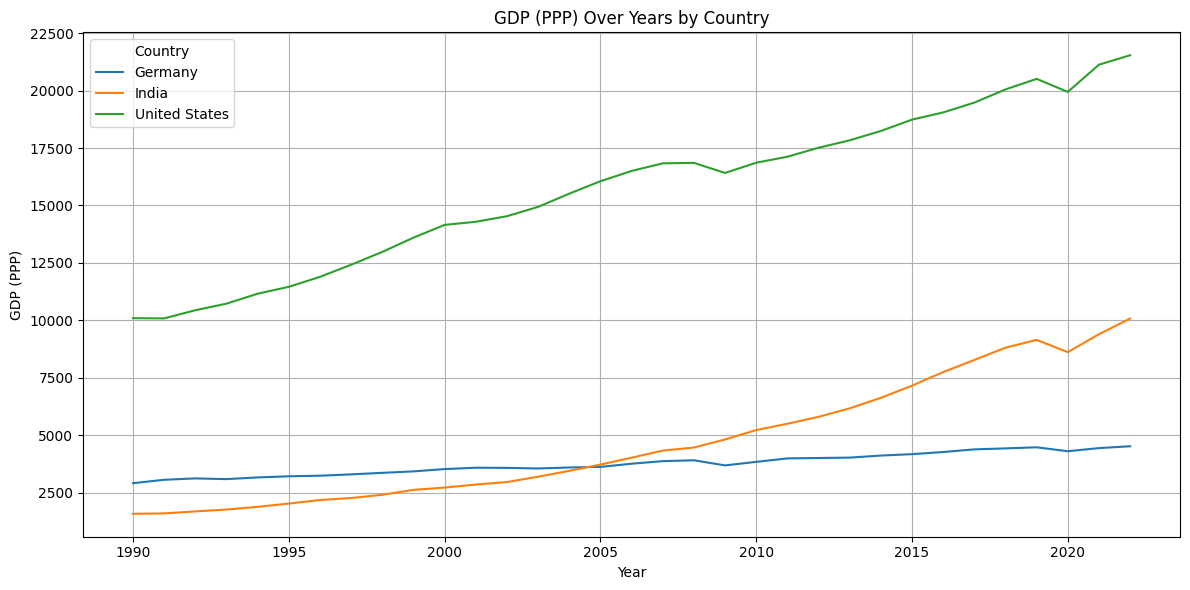

In [223]:
# Create the line chart
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=data,
    x='Year',
    y='gdp_ppp',
    hue='Entity',  # Different lines for each country
    palette='tab10'  # Optional color palette
)

# Customize the plot
plt.title('GDP (PPP) Over Years by Country')
plt.xlabel('Year')
plt.ylabel('GDP (PPP)')
plt.legend(title='Country')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [195]:
result_df.to_csv(artifacts_path+'results.csv',index=False)